In [1]:
import pandas as pd

dfs=[]

for s in ["anger","joy","sadness","fear"]:
    dfs.append(pd.read_csv(f"./dataset/WassaTrainData_{s}.txt", sep="\t",header=None, names=["index","content","sentiment","intensity"]))   
df=pd.concat(dfs,axis=0).sample(frac=1).reset_index(drop=True)
print("Number of records:",len(df))
df.drop(["index","intensity"],axis=1,inplace=True)
df.head()

Number of records: 3613


,content,sentiment
0,@FraserKeegan just had a steak pie supper #tre...,fear
1,@lesyoung01 a rabid dog being ridden by the ch...,anger
2,"By the way, I'm wearing the smile you gave me ...",joy
3,@StephenKing\n\nStephen King never once spoke ...,fear
4,@Callidissima @ahouseingotham wrath of khan is...,anger


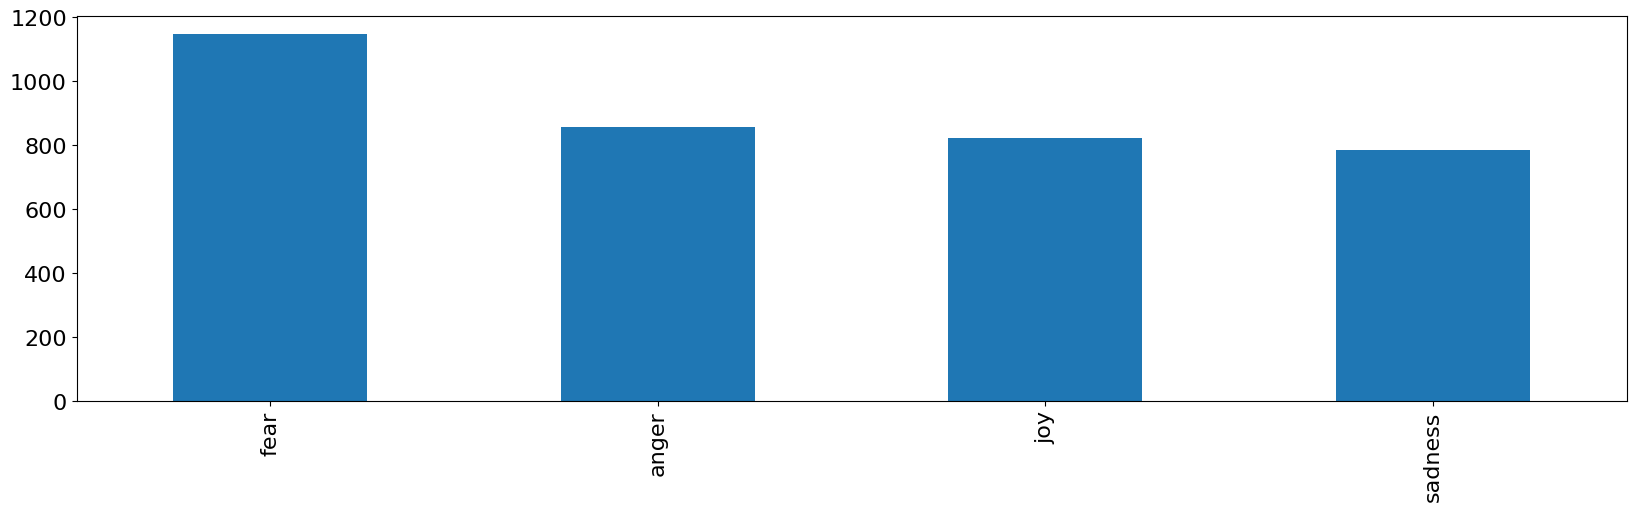

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (20, 5)})
df.sentiment.value_counts().plot(kind='bar',fontsize=16)
plt.show()


In order to have a larger dataset, we are going to import test data from the Wassa 2017 competition and use them as train data.

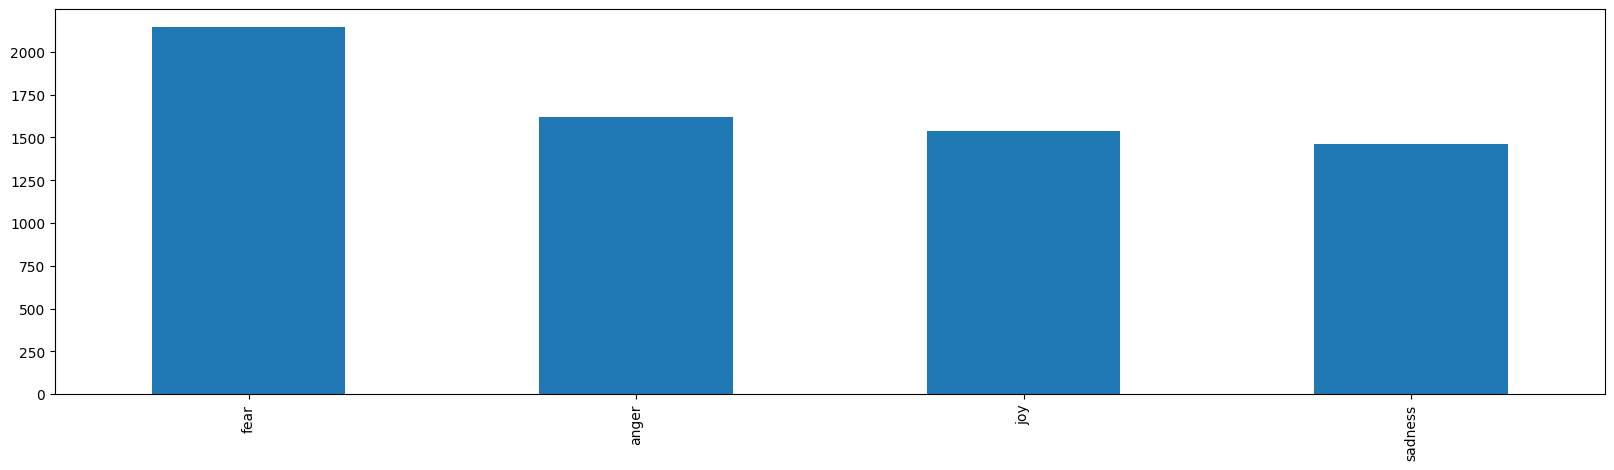

In [3]:
dfs=[df]
for s in ["anger","joy","sadness","fear"]:
    df_temp=pd.read_csv(f"./dataset/WassaTrainData_{s}_2.txt", sep="\t",header=None, names=["index","content","sentiment","intensity"])
    df_temp.drop(["index","intensity"],axis=1,inplace=True)
    dfs.append(df_temp)   

df=pd.concat(dfs,axis=0).sample(frac=1).reset_index(drop=True)

plt.rcParams.update({'figure.figsize': (20, 5)})
df.sentiment.value_counts().plot(kind='bar')
plt.show()

Now let's undersample the dataset so that it can be more balanced.

In [4]:
df.sentiment.value_counts()

fear       2142
anger      1617
joy        1537
sadness    1459
Name: sentiment, dtype: int64

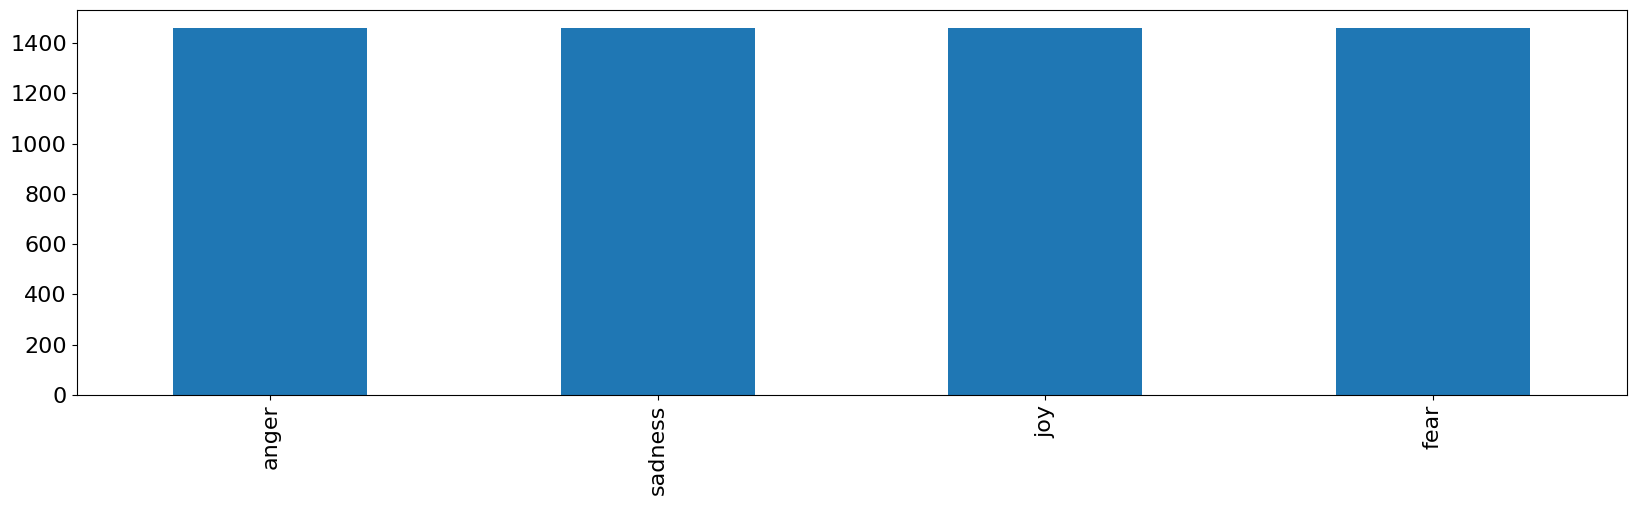

In [5]:
num_fear=len(df[df['sentiment']=='fear'])
num_anger=len(df[df['sentiment']=='anger'])
num_joy=len(df[df['sentiment']=='joy'])
num_sadness=len(df[df['sentiment']=='sadness'])
num_per_sentiment=min(num_fear,num_anger,num_joy,num_sadness)   #find the the category with the least number of records

fear_sample=df[df['sentiment']=='fear'].sample(frac=num_per_sentiment/num_fear)    #select a number of records equal to the least number
anger_sample=df[df['sentiment']=='anger'].sample(frac=num_per_sentiment/num_anger) 
joy_sample=df[df['sentiment']=='joy'].sample(frac=num_per_sentiment/num_joy)
sadness_sample=df[df['sentiment']=='sadness'].sample(frac=num_per_sentiment/num_sadness)

df=pd.concat([fear_sample,anger_sample,joy_sample,sadness_sample],axis=0).sample(frac=1).reset_index(drop=True) #concatenate the samples, shuffle and reset index

df.sentiment.value_counts().plot(kind='bar',fontsize=16)
plt.show()


In [6]:
#a function that tokenize the text using nltk library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import contractions
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess(sentence):
    not_contracted=[contractions.fix(w) for w in sentence.split()] #contractions expanding in order to keep "not" next
    filtered_words = [word for word in not_contracted if not word.startswith('@')] #remove mentions
    filtered_words = [word for word in filtered_words if not word.startswith('http')] #remove urls
    sentence = ' '.join(filtered_words) 
    tokens = word_tokenize(sentence)    #tokenization
    tokens = [w.lower() for w in tokens]    #remove the upper case
    table = str.maketrans('', '', string.punctuation)   #remove punctuation
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]    #remove words with numbers
    stop_words = stopwords.words('english')
    stop_words.remove("not")    #preserve negative terms because they could be significant to determine sentiment
    stop_words.remove("no")     
    stop_words.remove("nor")
    words = [w for w in words if not w in stop_words]   #remove stop words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]    #lemmatize
    return words


df["tokens"]=df['content'].apply(preprocess)
df["joined_tokens"]=df['tokens'].apply(lambda x: ' '.join(x))

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,sentiment,tokens,joined_tokens
0,i had an hour of football practice under the b...,anger,"[hour, football, practice, boiling, sun, volle...",hour football practice boiling sun volleyball ...
1,@reecetop10 Bk to 1 up top pack midfield Stifl...,sadness,"[bk, top, pack, midfield, stifle, flair, posse...",bk top pack midfield stifle flair posse kill e...
2,Who the hell is drilling outside my house?! Li...,anger,"[hell, drilling, outside, house, literally, go...",hell drilling outside house literally got slee...
3,A pessimist sees the difficulty in every oppor...,sadness,"[pessimist, see, difficulty, every, opportunit...",pessimist see difficulty every opportunity opt...
4,"Accept the challenges, so that you may feel th...",joy,"[accept, challenge, may, feel, exhilaration, v...",accept challenge may feel exhilaration victory


In [7]:
#removing duplicated text if present

if not df[df['joined_tokens'].duplicated() == True].empty:
    print("The dataset has some duplicated records!")
    print("Removing...")
    df = df.drop_duplicates(subset='joined_tokens', keep='first')
    print("Done")
else:
    print("The dataset has no duplicated rows!")

The dataset has some duplicated records!
Removing...
Done


# Bag od Words

## Multinomial Logistic Regression

Model parameters:  ((1, 2), 'lbfgs')
Accuracy:  0.8762243989314337
Classification report: 
               precision    recall  f1-score   support

       anger       0.89      0.85      0.87       283
        fear       0.88      0.82      0.85       286
         joy       0.88      0.95      0.91       278
     sadness       0.85      0.89      0.87       276

    accuracy                           0.88      1123
   macro avg       0.88      0.88      0.88      1123
weighted avg       0.88      0.88      0.88      1123



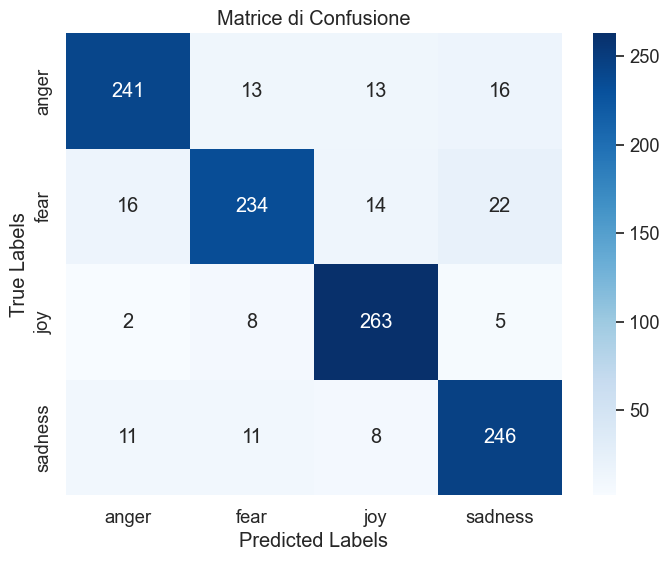

In [8]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
solvers=['lbfgs', 'liblinear']
accuracies={}
for ngram in ngrams:
    for solv in solvers:

        logreg = make_pipeline(TfidfVectorizer(ngram_range=ngram), LogisticRegression(solver=solv))
        logreg.fit(X_train, y_train)
        y_pred=logreg.predict(X_test)

        accuracies[(ngram,solv)]=accuracy_score(y_test, y_pred) #save the accuracy of each model in order to compare them and select the best one

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

#re train the model with the best parameters 
logreg = make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]), LogisticRegression(solver=sorted_accuracies[0][0][1]))
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification report: \n",classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()


## Random Forest

Model parameters:  ((1, 2), 150, 'entropy')
Accuracy: 0.8423864648263579
Classification report: 
 <function classification_report at 0x000001A4AF22BD90>


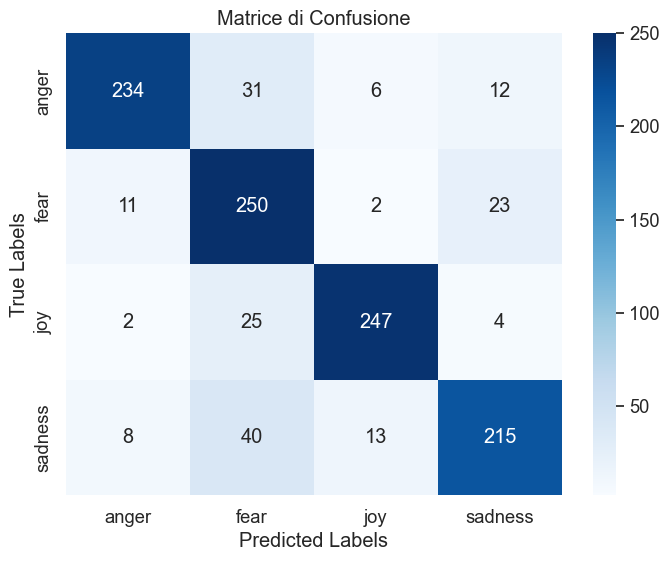

In [9]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
n_estimators=[50,100,150,200]
losses=['gini', 'entropy', 'log_loss']
accuracies={}
for ngram in ngrams:
    for n_est in n_estimators:
        for loss in losses:
            rfc = make_pipeline(TfidfVectorizer(ngram_range=ngram), RandomForestClassifier(n_estimators=n_est, criterion=loss))
            rfc.fit(X_train, y_train)
            y_pred=rfc.predict(X_test)
            accuracies[(ngram,n_est,loss)]=accuracy_score(y_test, y_pred)

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

#re train the model with the best parameters
rfc = make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]), 
                    RandomForestClassifier(n_estimators=sorted_accuracies[0][0][1], criterion=sorted_accuracies[0][0][2]))
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report: \n",classification_report)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()

## SVM


Model parameters:  ((1, 2), 'linear')
Accuracy: 0.9180765805877115
Classification Report:
               precision    recall  f1-score   support

       anger       0.93      0.92      0.93       283
        fear       0.91      0.91      0.91       286
         joy       0.93      0.94      0.93       278
     sadness       0.90      0.90      0.90       276

    accuracy                           0.92      1123
   macro avg       0.92      0.92      0.92      1123
weighted avg       0.92      0.92      0.92      1123



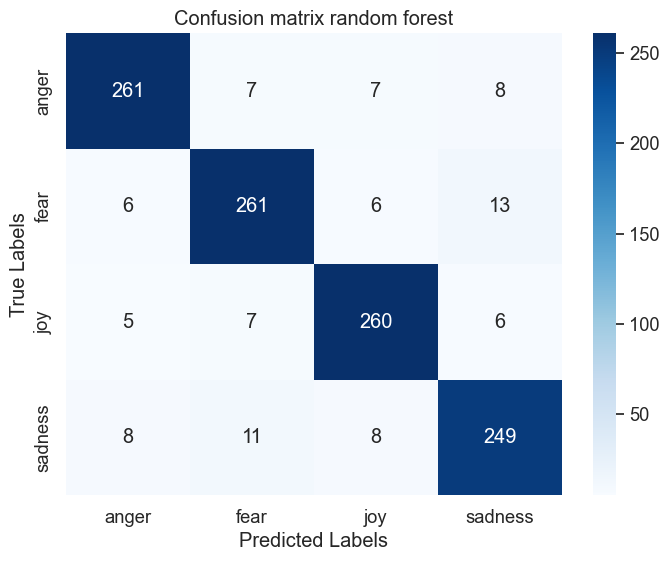

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
kernels=['linear', 'poly', 'rbf', 'sigmoid']
accuracies={}
for ngram in ngrams:
    for k in kernels:
        svm= make_pipeline(TfidfVectorizer(ngram_range=ngram),SVC(kernel=k))
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        accuracies[(ngram,k)]=accuracy_score(y_test, y_pred)

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

svm= make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]),SVC(kernel=sorted_accuracies[0][0][1]))
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


#print results
print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()

# Glove

In [11]:
from gensim.models import KeyedVectors
import numpy as np

# Load pre trained glove
embeddings_model_100 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.100d.txt', binary=False, no_header=True)
embeddings_model_200 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.200d.txt', binary=False, no_header=True)
embeddings_model_300 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

def tokens2vec(tokens,emb_model,dim,method='mean'):
    embeddings = []
    for token in tokens:
        try:
            embedding = emb_model[token]  
            embeddings.append(embedding)
        except KeyError:
            pass
    if embeddings:
        if method=='mean':
            return np.mean(embeddings, axis=0)
        elif method=='sum':
            return np.sum(embeddings, axis=0)
    else:
        return np.zeros(dim)



## Logistic Regression

Model with vector size 300 and solver lbfgs 
Accuracy:  0.7008014247551202
Classification Report:
                precision    recall  f1-score   support

       anger       0.71      0.72      0.72       283
        fear       0.66      0.62      0.64       286
         joy       0.76      0.78      0.77       278
     sadness       0.68      0.68      0.68       276

    accuracy                           0.70      1123
   macro avg       0.70      0.70      0.70      1123
weighted avg       0.70      0.70      0.70      1123



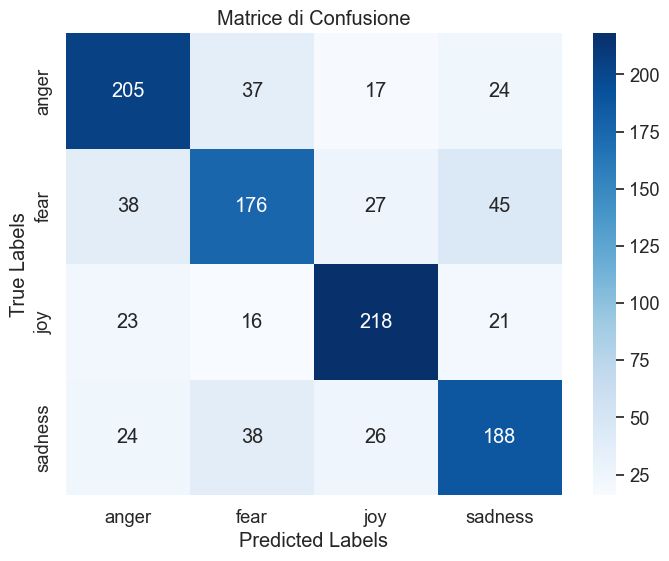

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

accuracies={}
for dim in [100,200,300]:
    for solv in ['lbfgs','liblinear']:
        
        logistic_regression = LogisticRegression(max_iter=1000,solver=solv)

        if dim== 100: 
            logistic_regression.fit(X_train_100, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_100))
        elif dim==200: 
            logistic_regression.fit(X_train_200, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_200))
        else: 
            logistic_regression.fit(X_train_300, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_300))
        
        accuracies[(dim,solv)]=accuracy_score(y_test,y_pred)
        
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)


logistic_regression = LogisticRegression(max_iter=1000,solver=sorted_accuracies[0][0][1])
if sorted_accuracies[0][0][0]==100:
    logistic_regression.fit(X_train_100, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    logistic_regression.fit(X_train_200, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_200))
else:
    logistic_regression.fit(X_train_300, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_300))
print(f"Model with vector size {sorted_accuracies[0][0][0]} and solver {sorted_accuracies[0][0][1]} ")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ',classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()

## Random Forest

Model with vector size 300, 200 trees and criterion=log_loss 
Accuracy:  0.691006233303651
Classification Report:
                precision    recall  f1-score   support

       anger       0.68      0.79      0.73       283
        fear       0.67      0.64      0.66       286
         joy       0.71      0.79      0.75       278
     sadness       0.70      0.54      0.61       276

    accuracy                           0.69      1123
   macro avg       0.69      0.69      0.69      1123
weighted avg       0.69      0.69      0.69      1123



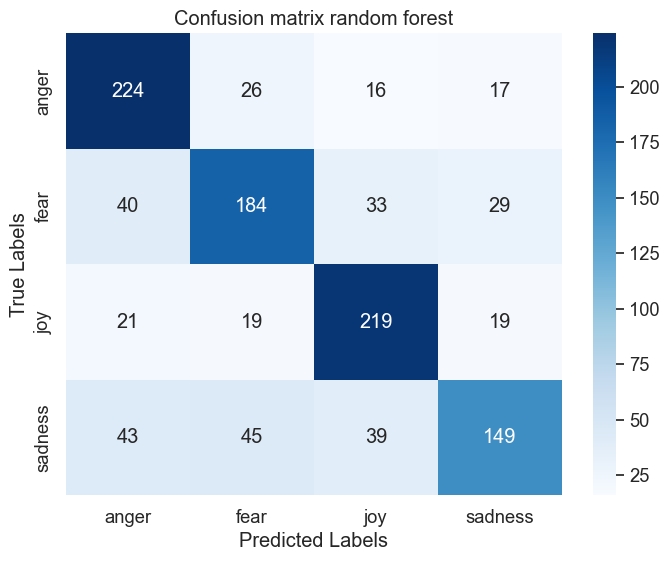

In [13]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

losses=['gini', 'entropy', 'log_loss']
n_estim=[50,100,200]
accuracies={}
for dim in [100,200,300]:
    for n in n_estim:
        for loss in losses:

            rfc = RandomForestClassifier(n_estimators=n,criterion=loss)
        if dim== 100: 
            rfc.fit(X_train_100, y_train)
            y_pred = rfc.predict(np.array(X_test_100))
        elif dim==200: 
            rfc.fit(X_train_200, y_train)
            y_pred = rfc.predict(np.array(X_test_200))
        else: 
            rfc.fit(X_train_300, y_train)
            y_pred = rfc.predict(np.array(X_test_300))
        
        accuracies[(dim,n,loss)]=accuracy_score(y_test,y_pred)

sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)
 
rfc = RandomForestClassifier(n_estimators=sorted_accuracies[0][0][1],criterion=sorted_accuracies[0][0][2])
if sorted_accuracies[0][0][0]==100:
    rfc.fit(X_train_100, y_train)
    y_pred = rfc.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    rfc.fit(X_train_200, y_train)
    y_pred = rfc.predict(np.array(X_test_200))
else:
    rfc.fit(X_train_300, y_train)
    y_pred = rfc.predict(np.array(X_test_300))

print(f"Model with vector size {sorted_accuracies[0][0][0]}, {sorted_accuracies[0][0][1]} trees and criterion={sorted_accuracies[0][0][2]} ")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ',classification_report(y_test, y_pred))
#confusion matrix
confusion = confusion_matrix(y_test, y_pred)
#plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()


## SVM

Model with vector size 300 and kerel=linear
Accuracy: 0.6812110418521816
Classification Report:
               precision    recall  f1-score   support

       anger       0.70      0.68      0.69       283
        fear       0.63      0.66      0.64       286
         joy       0.75      0.74      0.75       278
     sadness       0.65      0.64      0.65       276

    accuracy                           0.68      1123
   macro avg       0.68      0.68      0.68      1123
weighted avg       0.68      0.68      0.68      1123



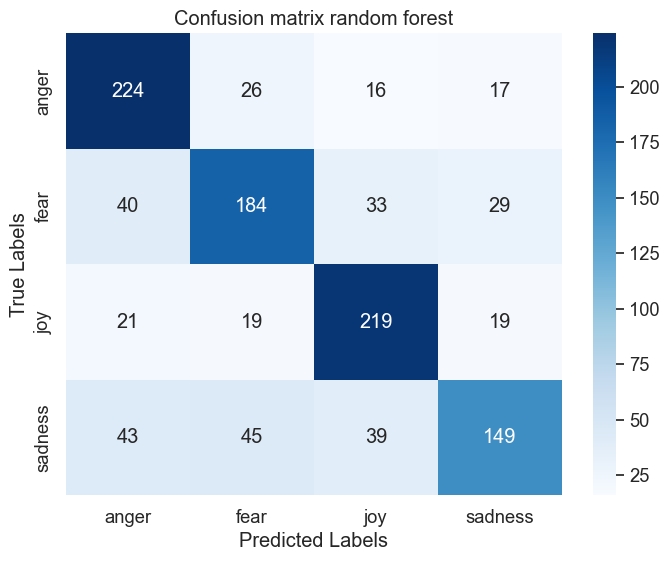

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

kernels=['linear', 'poly', 'rbf', 'sigmoid']
accuracies={}

for dim in [100,200,300]:
    for k in kernels:

        svm = SVC(kernel='rbf') 

        if dim== 100: 
            svm.fit(X_train_100, y_train)
            y_pred = svm.predict(np.array(X_test_100))
        elif dim==200: 
            svm.fit(X_train_200, y_train)
            y_pred = svm.predict(np.array(X_test_200))
        else: 
            svm.fit(X_train_300, y_train)
            y_pred = svm.predict(np.array(X_test_300))
        
        accuracies[(dim,k)]=accuracy_score(y_test,y_pred)

sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

svm = SVC(kernel=sorted_accuracies[0][0][1]) 

if sorted_accuracies[0][0][0]==100:
    svm.fit(X_train_100, y_train)
    y_pred = svm.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    svm.fit(X_train_200, y_train)
    y_pred = svm.predict(np.array(X_test_200))
else:
    svm.fit(X_train_300, y_train)
    y_pred = svm.predict(np.array(X_test_300))

#print results
print(f"Model with vector size {sorted_accuracies[0][0][0]} and kerel={sorted_accuracies[0][0][1]}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
#plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Imposta la dimensione del carattere per la heatmap
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()

## NN

In [15]:
#first let's one hot encode the labels
def oneHotEncode(val,dictionary):
    arr=np.zeros(len(dictionary))
    arr[dictionary[val]]=1
    return arr

oneHotDict={key:val for val,key in enumerate(df.sentiment.unique())}

df['label']=df['sentiment'].apply(lambda x: oneHotEncode(x,oneHotDict))
df.head()

,content,sentiment,tokens,joined_tokens,label
0,i had an hour of football practice under the b...,anger,"[hour, football, practice, boiling, sun, volle...",hour football practice boiling sun volleyball ...,"[1.0, 0.0, 0.0, 0.0]"
1,@reecetop10 Bk to 1 up top pack midfield Stifl...,sadness,"[bk, top, pack, midfield, stifle, flair, posse...",bk top pack midfield stifle flair posse kill e...,"[0.0, 1.0, 0.0, 0.0]"
2,Who the hell is drilling outside my house?! Li...,anger,"[hell, drilling, outside, house, literally, go...",hell drilling outside house literally got slee...,"[1.0, 0.0, 0.0, 0.0]"
3,A pessimist sees the difficulty in every oppor...,sadness,"[pessimist, see, difficulty, every, opportunit...",pessimist see difficulty every opportunity opt...,"[0.0, 1.0, 0.0, 0.0]"
4,"Accept the challenges, so that you may feel th...",joy,"[accept, challenge, may, feel, exhilaration, v...",accept challenge may feel exhilaration victory,"[0.0, 0.0, 1.0, 0.0]"


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["label"], test_size=0.2, stratify=df["sentiment"])

X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_test])
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_test])
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_test])

y_train=np.array(y_train.to_list())
y_test=np.array(y_test.to_list())

accuracies={}

for config in [(128,128),(256,256),(256,128),(512,256)]:
    for dim in [100,200,300]:

        model=Sequential(
            [
                Dense(config[0], input_shape=(dim,), activation='relu'),
                Dropout(0.5),
                Dense(config[1], activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
            ]
        )

        model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
        if dim==100:
            model.fit(X_train_100, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_100, y_test)
        elif dim==200:
            model.fit(X_train_200, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_200, y_test)
        else:
            model.fit(X_train_300, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_300, y_test)
        
        accuracies[(dim,config)]=val[1]

sorted_accuracies=sorted(accuracies.items(),key=lambda x: x[1],reverse=True)
nn_config=sorted_accuracies[0][0][1]
nn_vect_dim=sorted_accuracies[0][0][0]
nn_model=Sequential(
            [
                Dense(nn_config[0], input_shape=(nn_vect_dim,), activation='relu'),
                Dropout(0.5),
                Dense(nn_config[1], activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
            ]
        )
nn_model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

if nn_vect_dim==100:
    nn_model.fit(X_train_100, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_100, y_test)
elif nn_vect_dim==200:
    nn_model.fit(X_train_200, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_200, y_test)
else:
    nn_model.fit(X_train_300, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_300, y_test)

print(f"NN with two layers with size {nn_config} and vector size {nn_vect_dim}")

print("Accuracy: ",val[1])


36/36 [==============================] - 0s 1ms/step - loss: 1.2741 - accuracy: 0.7614
NN with two layers with size (512, 256) and vector size 300
Accuracy:  0.7613534927368164


# Cross validation

Let's compare the models using the k-fold cross validation.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


k = 5
kf = StratifiedKFold(n_splits=k, shuffle=False) #stratified k fold cross validation in order to obtain balanced folds

#BOW models

X=df["joined_tokens"]
y=df["sentiment"]

logreg = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression(solver='lbfgs'))
rfc= make_pipeline(TfidfVectorizer(ngram_range=(1,3)), RandomForestClassifier(n_estimators=100, criterion='entropy'))
svm=make_pipeline(TfidfVectorizer(ngram_range=(1,2)),SVC(kernel='sigmoid'))

for model in {"Logistic Regression": logreg,"Random Forest":rfc,"SVM":svm}.items():
    scores = cross_validate(model[1], X, y, cv=kf, scoring=['accuracy', 'precision_macro','recall_macro','f1_macro'])
    print(f'{model[0]} with TF-IDF')
    print('\t', "Accuracy: ", scores['test_accuracy'].mean() )
    print('\t', "Precision: ", scores['test_precision_macro'].mean() )
    print('\t', "Recall: ", scores['test_recall_macro'].mean() )
    print('\t', "F1: ", scores['test_f1_macro'].mean() )

# GLOVE models

#we import only the 300d glove model because the hyper-parameter tuning of every model showed us the same result relatively the vector size
embed_model = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True) 

X = np.array([ tokens2vec(t,embed_model,300) for t in df["tokens"] ])
y = df["sentiment"].values

logreg=LogisticRegression(max_iter=1000,solver='liblinear')
rfc=RandomForestClassifier(n_estimators=200,criterion='log_loss')
svm=SVC(kernel='linear') 

for model in {"Logistic Regression": logreg,"Random Forest":rfc,"SVM":svm}.items():
    scores = cross_validate(model[1], X, y, cv=kf, scoring=['accuracy', 'precision_macro','recall_macro','f1_macro'])
    print(f'{model[0]} with GloVe')
    print('\t', "Accuracy: ", scores['test_accuracy'].mean() )
    print('\t', "Precision: ", scores['test_precision_macro'].mean() )
    print('\t', "Recall: ", scores['test_recall_macro'].mean() )
    print('\t', "F1: ", scores['test_f1_macro'].mean() )

Logistic Regression with TF-IDF
	 Accuracy:  0.8827957962104943
	 Precision:  0.8830091440284378
	 Recall:  0.8829203431843584
	 F1:  0.8826702269173543
Random Forest with TF-IDF
	 Accuracy:  0.8649792143846934
	 Precision:  0.8681227359598769
	 Recall:  0.8650382748882726
	 F1:  0.8654446320795097
SVM with TF-IDF
	 Accuracy:  0.8947295489069098
	 Precision:  0.895211728097544
	 Recall:  0.894936730403231
	 F1:  0.8947582118486459
Logistic Regression with GloVe
	 Accuracy:  0.7039539494256376
	 Precision:  0.7042181395786269
	 Recall:  0.7041508999641304
	 F1:  0.703940984983426
Random Forest with GloVe
	 Accuracy:  0.6895294149392939
	 Precision:  0.6895301385187144
	 Recall:  0.6893121571465664
	 F1:  0.6865578987682874
SVM with GloVe
	 Accuracy:  0.693804950135158
	 Precision:  0.6953771023059043
	 Recall:  0.6939442627116418
	 F1:  0.6942491920357969


In [46]:
import tensorflow as tf

X=df["tokens"]
y=df['sentiment']

nn_accuracies=[]
nn_precision=[]
nn_recall=[]
nn_f1=[]
for train_index, val_index in kf.split(X, y):
    X_train, X_val = np.array([tokens2vec(t,embeddings_model_300,300) for t in X.iloc[train_index]]),\
                    np.array([tokens2vec(t,embeddings_model_300,300) for t in X.iloc[val_index]])
    y_train, y_val = np.array(y.iloc[train_index].apply(lambda x: oneHotEncode(x,oneHotDict)).tolist()), \
                    np.array(y.iloc[val_index].apply(lambda x: oneHotEncode(x,oneHotDict)).tolist())

    model=Sequential(
        [
            Dense(256, input_shape=(300,), activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(4, activation='softmax')
        ]
    )

    model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.F1Score(average='macro')])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Evaluate the model on the validation set
    _, acc, recall, precision, f1 = model.evaluate(X_val, y_val, verbose=0)

    nn_accuracies.append(acc)
    nn_precision.append(precision)
    nn_recall.append(recall)
    nn_f1.append(f1)

# Calculate and display the mean and standard deviation of accuracies
mean_accuracy = np.mean(nn_accuracies)
mean_precision = np.mean(nn_precision)
mean_recall = np.mean(nn_recall)
mean_f1 = np.mean(nn_f1)

print(f"NN mean Accuracy: {mean_accuracy:.4f}")
print(f"NN mean Recall: {mean_precision:.4f}")
print(f"NN mean Precision: {mean_recall:.4f}")
print(f"NN mean F1: {mean_f1:.4f}")





NN mean Accuracy: 0.7606
NN mean Recall: 0.7726
NN mean Precision: 0.7501
NN mean F1: 0.7613


# Bert

In [49]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
from datasets import Dataset
from huggingface_hub import notebook_login

def tokenize_text(example):
    return tokenizer(example["text"], truncation=True)

id2label={0:"anger", 1:"joy", 2:"sadness", 3:"fear"}
label2id={"anger":0, "joy":1, "sadness":2, "fear":3}

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
y_train=y_train.apply(lambda x: label2id[x])
y_test=y_test.apply(lambda x: label2id[x])
train_dataset = Dataset.from_dict(pd.concat([X_train,y_train],axis=1).rename(columns={"sentiment": "label", "joined_tokens": "text"}))
train_dataset=train_dataset.map(tokenize_text,batched=True)
test_dataset = Dataset.from_dict(pd.concat([X_test,y_test],axis=1).rename(columns={"sentiment": "label", "joined_tokens": "text"}))
test_dataset=test_dataset.map(tokenize_text,batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/4496 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [43]:

notebook_login()


In [50]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

def compute_accuracy(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels,predictions)}


training_args = TrainingArguments(
    output_dir="bert-base-uncased-fine-tuned",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",  
    load_best_model_at_end=True,
    push_to_hub=True,
)

# comment this section if you want to use a model already fine tuned instead of training it on your data (and obvoiusly remove comment from the next section)
#----------------------------------------
trainer = Trainer(
    model=BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy,
)
trainer.train() 
#----------------------------------------

#remove comment by this section if you want to import a fine tuned model
#----------------------------------------
# trainer = Trainer(
#     model=BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased-fine-tuned", num_labels=4, id2label=id2label, label2id=label2id
# ),
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_accuracy,
# )

# trainer.evaluate()
#-----------------------------------------

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

TrainOutput(global_step=282, training_loss=0.7466774257362312, metrics={'train_runtime': 1640.7776, 'train_samples_per_second': 5.48, 'train_steps_per_second': 0.172, 'train_loss': 0.7466774257362312, 'epoch': 2.0})

# Movie Dialogs Analysis

In [8]:
from convokit import Corpus, download

corpus = Corpus(filename=download("movie-corpus"))

No configuration file found at C:\Users\Alessio/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [32]:
utterances=corpus.get_utterances_dataframe().rename(columns={"meta.movie_id":"movie_id"}).drop(columns=['timestamp',"meta.parsed","vectors"]) #drop 'timestamp' because all None values

conversations=corpus.get_conversations_dataframe().rename(columns={'meta.movie_name': 'movie_name',"meta.movie_idx":"movie_id"})\
                .drop(columns=['meta.rating',"meta.release_year","vectors","meta.votes","meta.genre"])

speakers=corpus.get_speakers_dataframe().rename(columns={'meta.movie_name': 'movie_name',"meta.movie_idx":"movie_id","meta.character_name":"character_name"})\
                .drop(columns=["meta.gender","meta.credit_pos","vectors"])

In [33]:
film_conversations=conversations[conversations.movie_name=="good will hunting"].sort_index()
film_speakers=speakers[speakers.movie_name=="good will hunting"].sort_index()
film_utterances=utterances[utterances.movie_id=='m373'].sort_index()

In [34]:
film_utterances["character_name"]=film_utterances['speaker'].apply(lambda x: film_speakers.at[f"{x}",'character_name'] )

In [12]:
#let's group conversations in the movie associating each one with the character involved
conv={}
for u in film_utterances.index:
    if film_utterances.at[f'{u}',"conversation_id"] in conv:
        conv[film_utterances.at[f'{u}',"conversation_id"]].append(film_utterances.at[f'{u}',"character_name"])
    else:
        conv[film_utterances.at[f'{u}',"conversation_id"]]=[film_utterances.at[f'{u}',"character_name"]]


In [13]:
#since we want to study the emotional profile of the main character (Will), let's drop all the conversations without him
for k in list(conv.keys()):
    if "WILL" not in conv[k]:
        conv.pop(k)
conv

{'L249456': ['WILL', 'CHUCKIE'],
 'L249462': ['WILL', 'MORGAN'],
 'L249472': ['CHUCKIE', 'WILL'],
 'L249482': ['CHUCKIE', 'WILL'],
 'L249484': ['CHUCKIE', 'WILL', 'CHUCKIE', 'WILL'],
 'L249506': ['WILL', 'MORGAN'],
 'L249511': ['WILL', 'CHUCKIE'],
 'L249526': ['WILL', 'CHUCKIE'],
 'L249530': ['WILL', 'CHUCKIE'],
 'L249534': ['WILL', 'MORGAN'],
 'L249536': ['CHUCKIE', 'WILL'],
 'L249545': ['CHUCKIE', 'WILL'],
 'L249551': ['CHUCKIE', 'WILL'],
 'L249555': ['WILL', 'LAMBEAU', 'WILL'],
 'L249558': ['LAMBEAU', 'WILL', 'LAMBEAU'],
 'L249561': ['MORGAN', 'WILL', 'MORGAN'],
 'L249605': ['SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR'],
 'L249614': ['WILL', 'SKYLAR', 'WILL', 'SKYLAR'],
 'L249618': ['WILL', 'SKYLAR', 'WILL', 'SKYLAR', 'WILL'],
 'L249624': ['MORGAN', 'WILL'],
 'L249654': ['SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL'],
 'L249662': ['LAMBEAU',
  'WILL',
  'LAMBEAU',
  'WILL',
  'LAMBEAU',
  'WIL

In [14]:
#recover all the expressions of the main character by associating them with who they refer to, in the format (utterance, character_name)

utterances_per_ch=[]
for k in conv:
    for r in film_utterances[film_utterances['conversation_id']==k].itertuples():
        if r.character_name=='WILL':
            utterances_per_ch.append((r.text,[n for n in conv[k] if n != 'WILL'][0]))



<h1> Application of the selected mode </h1>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

svm=make_pipeline(TfidfVectorizer(ngram_range=(1,2)),SVC(kernel='sigmoid'))
svm.fit(df['joined_tokens'], df['sentiment'])


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc', SVC(kernel='sigmoid'))])

In [16]:
emotions=[]
for u,c in utterances_per_ch:
    sentiment = svm.predict([' '.join(preprocess(u))])[0]
    emotions.append((sentiment,c))
emotions

[('anger', 'CHUCKIE'),
 ('sadness', 'MORGAN'),
 ('joy', 'CHUCKIE'),
 ('anger', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('anger', 'CHUCKIE'),
 ('joy', 'MORGAN'),
 ('fear', 'CHUCKIE'),
 ('sadness', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('sadness', 'MORGAN'),
 ('sadness', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('anger', 'LAMBEAU'),
 ('anger', 'MORGAN'),
 ('fear', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('anger', 'MORGAN'),
 ('joy', 'SKYLAR'),
 ('sadness', 'SKYLAR'),
 ('sadness', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('anger', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('sadness', 'LAMBEAU'),
 ('sadness', 'CHUCKIE'),
 ('joy', 'PSYCHOLOGIST'),
 ('sadness', 'PSYCHOLOGIST'),
 ('joy', 'PSYCHOLOGIST'),
 ('fear', 'PSYCHOLOGIST'),
 ('sadness', 'PSYCHOLOGIST'),
 ('joy', 'PSYCH

<AxesSubplot:xlabel='Character'>

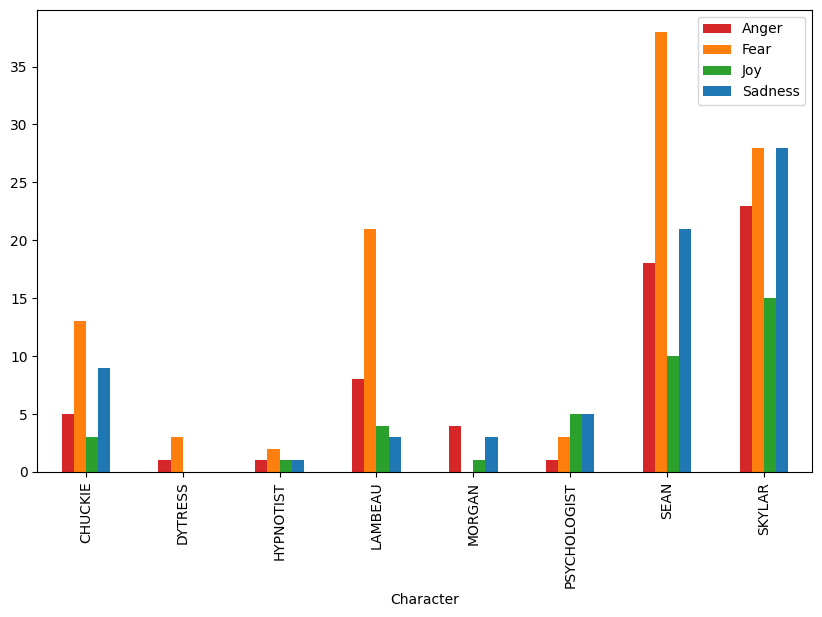

In [107]:
cmap={
    'Anger':'#d62728',
    'Sadness':'#ff7f0e',
    'Joy':'#2ca02c',
    'Fear':'#1f77b4' 
}

df = pd.DataFrame(emotions, columns=['Emotion', 'Name'])

df_pivot = df.pivot_table(index='Name', columns='Emotion', aggfunc='size', fill_value=0).reset_index()

df_pivot.columns.name = None  
emotions_expressed_per_ch = df_pivot.rename(columns={'Name': 'Character', 'anger': 'Anger', 'fear': 'Fear', 'sadness': 'Sadness', 'joy': 'Joy'})

emotions_expressed_per_ch.plot(x="Character",kind="bar",figsize=(10, 6),color=cmap.values())

Let's try to plot the emotional trend of the character


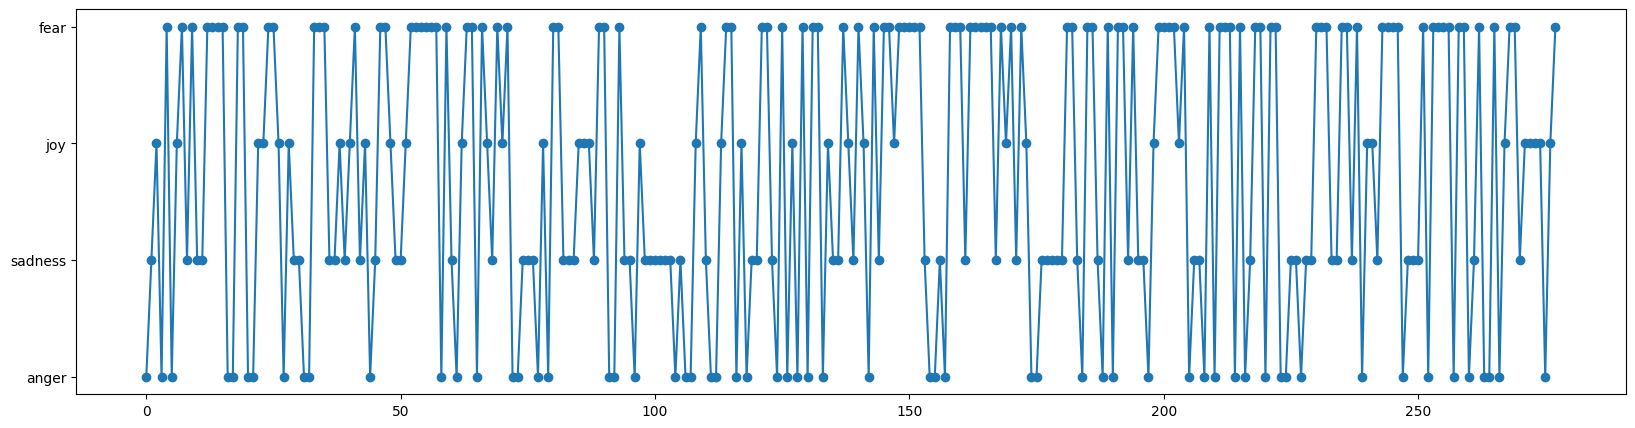

In [36]:
plt.plot(df.index, df["Emotion"], marker='o', linestyle='-')

Now let's group the conversation in 7 different time period in order to better understand the trend during the develompment of the story.


<AxesSubplot:xlabel='Period'>

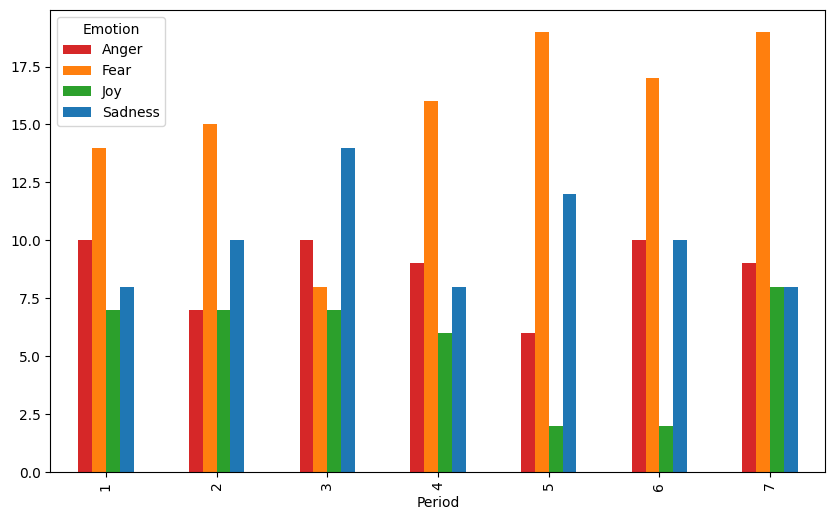

In [108]:

period_size = len(df) // 7
df['period'] = (df.index // period_size) + 1
df['period']=df['period'].apply(lambda x: 7 if x==8 else x) #

df_pivot = df.pivot_table(index='period', columns='Emotion', aggfunc='size', fill_value=0).reset_index()
df_pivot.columns.period = None  
emotions_in_time = df_pivot.rename(columns={'period': 'Period', 'anger': 'Anger', 'fear': 'Fear', 'sadness': 'Sadness', 'joy': 'Joy'})

emotions_in_time.plot(x="Period",kind="bar",figsize=(10, 6),color=cmap.values())

The next plot shows the emotional trend of the protagonist in relation to the character of Sean, a particularly important character within the story.

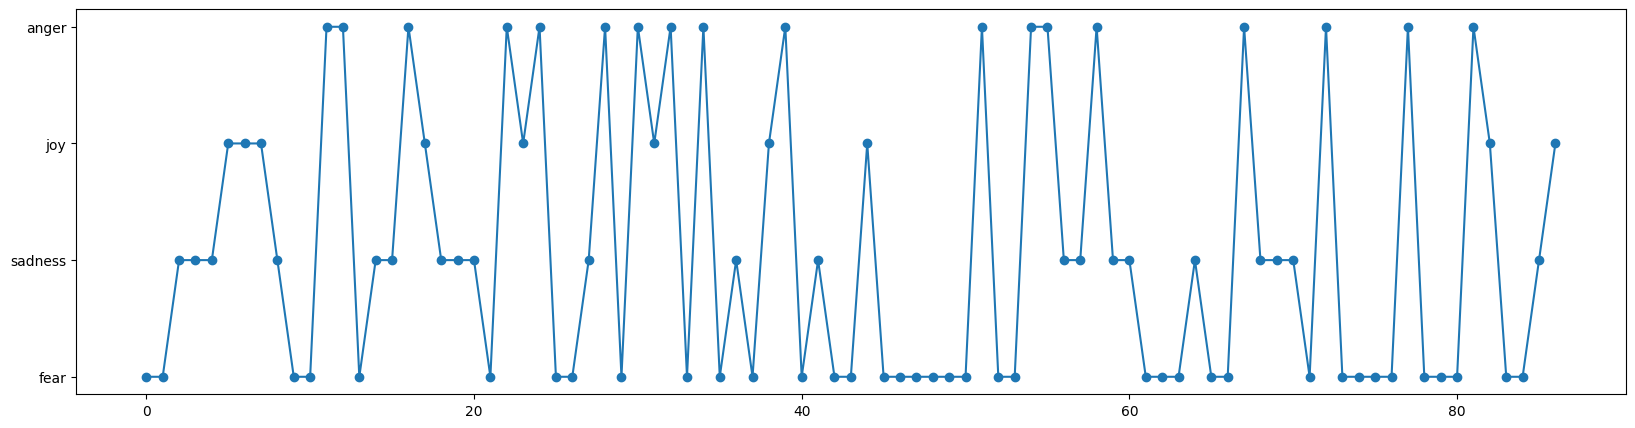

In [47]:
sean=df[df['Name']=="SEAN"].reset_index()
plt.plot(sean.index, sean["Emotion"], marker='o', linestyle='-')